In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
import math
pd.set_option('display.max_columns', None)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sm
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

## Preprocessing

There are  320 normally distributed features out of 320
There are  320 normally distributed features out of 320


C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

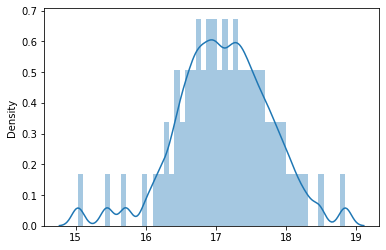

In [3]:
df1 = pd.read_csv("dataset\ADNI_coef_lm.csv")
df1.drop(['Unnamed: 0','(Intercept)','Age','GenderMale','yEdu'],axis=1,inplace=True)

df2 = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")
#replace categorical feature with index labeling
df2['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df2['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df2.loc[:,'RID':'VISCODE']
data = df2.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']
data['binary_class'] = pheno['binary_class']
data['three_class'] = pheno['three_class']
data['RID'] = pheno['RID']

#merge two datasets
df = pd.merge(df1, data, on="RID")
df.drop(['RID'],axis=1,inplace=True)

X = df.drop(columns = ['variable_num','binary_class','three_class'])
y = df["variable_num"]

#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])
    
#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(X)
data = df_qn
norm_test(data)

#compute box-cox transformation
df_bc = pd.DataFrame().reindex_like(data)

for col in df_qn:
    df_bc[col],_ = stats.boxcox(df_qn[col])
data = df_qn
norm_test(data)

#check if data is better normally distributed
sns.distplot(data)

## Test models using with PCA as feature selection

In [37]:
# Make an instance of the model keeping 95% of the features variance
pca = PCA(0.78)
# pca = PCA()

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
print('Note that we now have',principalDf.shape[1],'columns instead of',X.shape[1])

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(principalDf, y, test_size = 0.20, random_state = 97)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(principalDf, y, test_size = 0.40, random_state = 97)

Note that we now have 9 columns instead of 320


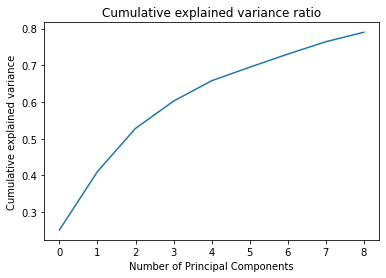

In [38]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative explained variance ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance');

### Compute performance of model

In [24]:
def check_acc(X_train,y_train,X_test,y_test,model):
    model.fit(X_train,y_train)
    
#     score = model.score(X_train, y_train)  
#     print("Training score: ", score)

    y_predicted = model.predict(X_test)

    rmse = math.sqrt(mean_squared_error(y_test, y_predicted))
    print("RMSE =", rmse)
    print("MAE =", mean_absolute_error(y_test, y_predicted), 2)
    
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_predicted, label="predicted")
    plt.ylabel('Decline slope')
    plt.xlabel('Patients')
    plt.legend()
    plt.show()

### Single xgb classifier

In [39]:
def XGB_class(X_train, X_test, y_train, y_test):
    clf = xgb.XGBRegressor()
    check_acc(X_train,y_train,X_test,y_test,clf)

Using 20% as test subset:
RMSE = 0.26052168748327176
MAE = 0.2182671368695116 2


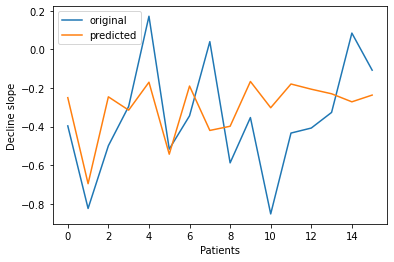

Using 40% as test subset:
RMSE = 0.2892610713150836
MAE = 0.2422758268959662 2


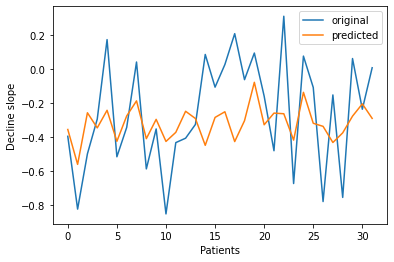

In [40]:
print('Using 20% as test subset:')
XGB_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
XGB_class(X_train_40,X_test_40,y_train_40,y_test_40)

### Simple Linear Regression

Using 20% as test subset:
RMSE = 0.3131505776471349
MAE = 0.2672510678532777 2


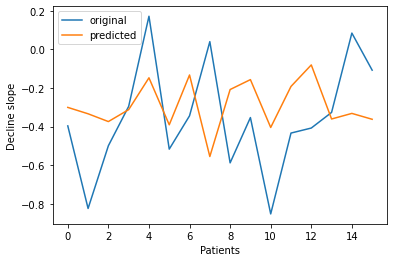

Using 40% as test subset:
RMSE = 0.32234574859535936
MAE = 0.2843303932947373 2


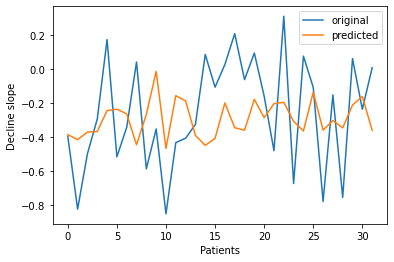

In [32]:
print('Using 20% as test subset:')
check_acc(X_train_20,y_train_20,X_test_20,y_test_20,LinearRegression())
print('Using 40% as test subset:')
check_acc(X_train_40,y_train_40,X_test_40,y_test_40,LinearRegression())

### Test which PCA variance is the best for XGBoost regressor model

In [20]:
variances = np.arange(0.5, 0.99, 0.01).tolist()
perf = []
for i in variances:
    # Make an instance of the model keeping 95% of the features variance
    pca = PCA(i)

    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents)

    X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size = 0.20, random_state = 97)
    
    reg = xgb.XGBRegressor()
    reg.fit(X_train, y_train)
    y_predicted = reg.predict(X_test)
    
    rmse = math.sqrt(mean_squared_error(y_test, y_predicted))    
    perf.append(rmse)

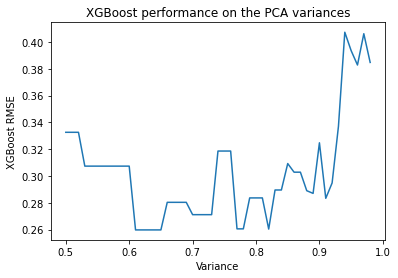

Best variances with XGBoost Regressor are [0.63, 0.78, 0.81].


In [47]:
plt.plot(variances, perf)
plt.xlabel('Variance') 
plt.ylabel('XGBoost RMSE') 
plt.title("XGBoost performance on the PCA variances")
plt.show()
print("Best variances with XGBoost Regressor are [0.63, 0.78, 0.81].")